In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv(
    'pfyh.csv',
    header=None,
    names=['date', 'open', 'high', 'low', 'close', 'ma5', 'ma10', 'volume'])
data

,date,open,high,low,close,ma5,ma10,volume
0,2018-01-02,12.61,12.77,12.60,12.73,12.624,12.650,313230.53
1,2018-01-03,12.73,12.80,12.66,12.67,12.630,12.642,378391.00
2,2018-01-04,12.70,12.73,12.62,12.66,12.638,12.637,278838.03
3,2018-01-05,12.67,12.71,12.62,12.69,12.668,12.636,310267.44
4,2018-01-08,12.69,12.71,12.63,12.68,12.686,12.642,313898.88
...,...,...,...,...,...,...,...,...
482,2019-12-25,12.29,12.29,12.20,12.24,12.310,12.249,136781.75
483,2019-12-26,12.26,12.32,12.23,12.29,12.286,12.288,157390.55
484,2019-12-27,12.25,12.43,12.25,12.32,12.266,12.308,279321.09
485,2019-12-30,12.27,12.36,12.12,12.34,12.294,12.329,410515.56


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 8 columns):
date      487 non-null object
open      487 non-null float64
high      487 non-null float64
low       487 non-null float64
close     487 non-null float64
ma5       487 non-null float64
ma10      487 non-null float64
volume    487 non-null float64
dtypes: float64(7), object(1)
memory usage: 30.6+ KB


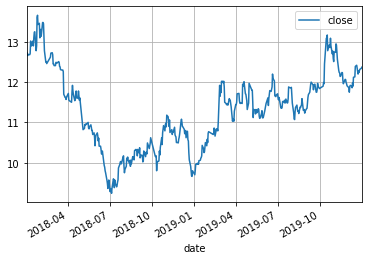

In [5]:
data['date'] = data['date'].astype('M8[D]')
data.plot(x='date', y='close', grid=True)

In [6]:
data.head()

,date,open,high,low,close,ma5,ma10,volume
0,2018-01-02,12.61,12.77,12.60,12.73,12.624,12.650,313230.53
1,2018-01-03,12.73,12.80,12.66,12.67,12.630,12.642,378391.00
2,2018-01-04,12.70,12.73,12.62,12.66,12.638,12.637,278838.03
3,2018-01-05,12.67,12.71,12.62,12.69,12.668,12.636,310267.44
4,2018-01-08,12.69,12.71,12.63,12.68,12.686,12.642,313898.88


In [7]:
# 传入时间,假设为当前日期,根据已知数据,返回策略
def profit(mdate):
    """
    基于均线理论,判断金叉死叉,返回响应结果
    """
    mask = data['date'] <= mdate
    if len(data[mask]) < 2:
        return 0
    today_data = data[mask].iloc[-1]
    yesday_data = data[mask].iloc[-2]
    #  昨天的5日均线与10日均线
    yma5, yma10 = yesday_data['ma5'], yesday_data['ma10']
    #  今天的5日均线与10日均线
    tma5, tma10 = today_data['ma5'], today_data['ma10']

    if (yma10 >= yma5) and (tma10 <= tma5):
        return 1
    elif (yma10 <= yma5) and (tma10 >= tma5):
        return -1
    return 0


profit_vec = np.vectorize(profit)
result = profit_vec(data['date'])
(result == 1).sum()

31

In [8]:
assets = 1000000
stocks = 0
payment_price = 0
status = 0
for index, profit in enumerate(result):
    current_price = data['close'][index]
    # 如果是买入并且赔了的状态，若已经跌出5%，则强制卖出
    if status == 1:
        payment_assets = payment_price * stocks
        current_assets = current_price * stocks
        if (payment_assets > current_assets) and (
            (payment_assets - current_assets) > payment_assets * 0.05):
            payment_price = current_price
            assets = assets + stocks * payment_price
            stocks = 0
            status = -1
            print('止损：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
                  format(data['date'][index], current_price, assets, stocks))
    if (profit == 1) and (status != 1):  # 买入
        payment_price = current_price
        stocks = int(assets / payment_price)
        assets = assets - stocks * payment_price
        status = 1
        print('买入：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
              format(data['date'][index], current_price, assets, stocks))
    if (profit == -1) and (status != -1):  # 卖出
        payment_price = current_price
        assets = assets + stocks * payment_price
        stocks = 0
        status = -1
        print('卖出：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
              format(data['date'][index], current_price, assets, stocks))
    print('持有：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.format(
        data['date'][index], current_price, assets, stocks))

持有：dates:2018-01-02 00:00:00, curr price:12.73, assets:1000000.00, stocks:0
持有：dates:2018-01-03 00:00:00, curr price:12.67, assets:1000000.00, stocks:0
买入：dates:2018-01-04 00:00:00, curr price:12.66, assets:11.92, stocks:78988
持有：dates:2018-01-04 00:00:00, curr price:12.66, assets:11.92, stocks:78988
持有：dates:2018-01-05 00:00:00, curr price:12.69, assets:11.92, stocks:78988
持有：dates:2018-01-08 00:00:00, curr price:12.68, assets:11.92, stocks:78988
持有：dates:2018-01-09 00:00:00, curr price:12.71, assets:11.92, stocks:78988
持有：dates:2018-01-10 00:00:00, curr price:13.02, assets:11.92, stocks:78988
持有：dates:2018-01-11 00:00:00, curr price:12.94, assets:11.92, stocks:78988
持有：dates:2018-01-12 00:00:00, curr price:12.90, assets:11.92, stocks:78988
持有：dates:2018-01-15 00:00:00, curr price:13.02, assets:11.92, stocks:78988
持有：dates:2018-01-16 00:00:00, curr price:12.90, assets:11.92, stocks:78988
持有：dates:2018-01-17 00:00:00, curr price:13.11, assets:11.92, stocks:78988
持有：dates:2018-01-18 00:

In [9]:
import tushare as ts

In [19]:
data = ts.get_hist_data('600848')
data = data.reset_index().sort_values('date')
data = data.reset_index()
data

,index,date,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
0,528,2017-11-20,25.55,25.58,25.09,23.46,125673.20,-0.98,-3.76,25.090,25.090,25.090,125673.20,125673.20,125673.20
1,527,2017-11-21,24.60,25.98,25.28,24.56,79894.52,0.17,0.68,25.185,25.185,25.185,102783.86,102783.86,102783.86
2,526,2017-11-22,25.21,25.90,25.26,24.84,68269.50,-0.03,-0.12,25.210,25.210,25.210,91279.07,91279.07,91279.07
3,525,2017-11-23,25.30,25.43,24.03,23.98,76386.50,-1.24,-4.91,24.915,24.915,24.915,87555.93,87555.93,87555.93
4,524,2017-11-24,24.10,24.70,24.45,24.09,53160.52,0.43,1.79,24.822,24.822,24.822,80676.85,80676.85,80676.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,4,2020-05-13,20.05,20.47,20.29,19.92,36803.57,0.23,1.15,20.352,19.923,19.690,54637.13,48858.28,41110.32
525,3,2020-05-14,20.10,20.45,20.18,20.05,31123.99,-0.11,-0.54,20.282,20.019,19.744,43659.31,49436.63,41504.87
526,2,2020-05-15,20.26,20.78,20.61,20.22,83237.98,0.43,2.13,20.288,20.159,19.807,48285.22,54436.13,44461.66
527,1,2020-05-18,20.50,20.88,20.53,20.42,60600.82,-0.08,-0.39,20.334,20.293,19.858,50837.18,58494.01,45386.82


In [24]:
data['date'] = data['date'].astype('M8[D]')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 15 columns):
index           529 non-null int64
date            529 non-null datetime64[ns]
open            529 non-null float64
high            529 non-null float64
close           529 non-null float64
low             529 non-null float64
volume          529 non-null float64
price_change    529 non-null float64
p_change        529 non-null float64
ma5             529 non-null float64
ma10            529 non-null float64
ma20            529 non-null float64
v_ma5           529 non-null float64
v_ma10          529 non-null float64
v_ma20          529 non-null float64
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 62.1 KB


In [20]:
result = profit_vec(data['date'])
(result == 1).sum()

34

In [26]:
assets = 1000000
stocks = 0
payment_price = 0
status = 0
for index, profit in enumerate(result):
    current_price = data['close'][index]
    # 如果是买入并且赔了的状态，若已经跌出5%，则强制卖出
    if status == 1:
        payment_assets = payment_price * stocks
        current_assets = current_price * stocks
        if (payment_assets > current_assets) and (
            (payment_assets - current_assets) > payment_assets * 0.05):
            payment_price = current_price
            assets = assets + stocks * payment_price
            stocks = 0
            status = -1
            print('止损：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
                  format(data['date'][index], current_price, assets, stocks))
    if (profit == 1) and (status != 1):  # 买入
        payment_price = current_price
        stocks = int(assets / payment_price)
        assets = assets - stocks * payment_price
        status = 1
        print('买入：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
              format(data['date'][index], current_price, assets, stocks))
    if (profit == -1) and (status != -1):  # 卖出
        payment_price = current_price
        assets = assets + stocks * payment_price
        stocks = 0
        status = -1
        print('卖出：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
              format(data['date'][index], current_price, assets, stocks))
    print('持有：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.format(
        data['date'][index], current_price, assets, stocks))

持有：dates:2017-11-20 00:00:00, curr price:25.09, assets:1000000.00, stocks:0
买入：dates:2017-11-21 00:00:00, curr price:25.28, assets:24.32, stocks:39556
持有：dates:2017-11-21 00:00:00, curr price:25.28, assets:24.32, stocks:39556
持有：dates:2017-11-22 00:00:00, curr price:25.26, assets:24.32, stocks:39556
持有：dates:2017-11-23 00:00:00, curr price:24.03, assets:24.32, stocks:39556
持有：dates:2017-11-24 00:00:00, curr price:24.45, assets:24.32, stocks:39556
卖出：dates:2017-11-27 00:00:00, curr price:24.21, assets:957675.08, stocks:0
持有：dates:2017-11-27 00:00:00, curr price:24.21, assets:957675.08, stocks:0
持有：dates:2017-11-28 00:00:00, curr price:24.70, assets:957675.08, stocks:0
持有：dates:2017-11-29 00:00:00, curr price:24.29, assets:957675.08, stocks:0
持有：dates:2017-11-30 00:00:00, curr price:24.25, assets:957675.08, stocks:0
持有：dates:2017-12-01 00:00:00, curr price:24.18, assets:957675.08, stocks:0
持有：dates:2017-12-04 00:00:00, curr price:22.92, assets:957675.08, stocks:0
持有：dates:2017-12-05 00:0

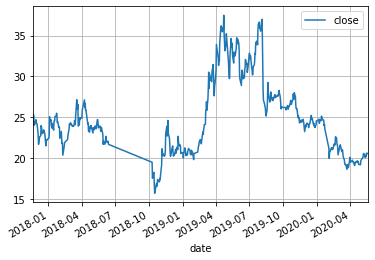

In [25]:
data.plot(x='date', y='close', grid=True)